In this notebook, we'll be modeling maximising the fuel efficiecny of a car

# Model

The cars dynamics will follow a simple dynamical law:

$$
m\frac{dv(t)}{dt} = u(t) - \mu(t) - F_w(t)
$$



where
 - $u(t)$ is the force that is generated by the engine
 - $\mu(t)$ is the resitance force
 - $v(t)$ is the velocity of the car
 - $F_w(t)$ is the wind force
 - $m$ is the mass of the car

The car will have a cruise control setting, $v_{s}$. In order to reach this setting, the car is free to control the acceleraation u(t). 

The resitance force is made up of rolling friction and aerodynamic drag:

$$
\mu(t) = k_0(1-\exp^{-v(t)})+k_1v(t)^2
$$

The amount of instantaneous fuel burn, $\zeta(t)$, of the car is proportional to u(t):

$$
\zeta(t) = \alpha_0 + \alpha_1 u(t)
$$
 
where $\alpha_0$ can be interpreted as the idle fuel burn. 

# Control Objective

The control objective is to control u(t) such that the velocity is $v_s$


# Strategic optimisation

As a driver, the best speed will be the speed that maximises intergated fuel efficiency, $\int_0^T \eta(t) dt$. More formally, $\eta(t)$ is defined as the amount of fuel burned per unit distance travelled. We can derive the equation of this over a finite time horizon, $T$, and take the limit as $T$-> 0 to obtain the instantaneous value:

$$
\eta(t) =\lim_{T->0} \frac{\int_0^T \zeta(t) dt}{\int_0^Tv(t)dt} = \frac{\zeta(t)}{v(t)}
$$

For the special case of constant speed at $v_s$ and constant head wind, $F_w(t) = H$ then we can derive the following expression for $\eta(t)$



$$
\eta(t) =\frac{\alpha_0 + \alpha_1 u(t)}{v_s}\\
=\frac{\alpha_0 + \alpha_1 (\mu(t) + F_w(t)) }{v_s}\\
=\frac{\alpha_0 + \alpha_1 (k_0(1-\exp^{-v(t)})+k_1v_s^2 + H) }{v_s}\\
\approx \frac{\alpha_0 + \alpha_1 (k_0+k_1v_s^2 + H) }{v_s}\\
=\frac{\alpha_0 + \alpha_1(k_0+H) + \alpha_1k_1v_s^2) }{v_s} \\
=\frac{\alpha_0 + \alpha_1(k_0+H) }{v_s} + \alpha_1k_1v_s
$$


The following expression is minimised at:

$$
\eta_{min} = \sqrt{\frac{\alpha_0 + \alpha_1(k_0+H)}{\alpha_1k_1}}
$$

# Problem

The problem though is that we only know nominal values of $\alpha_0$ and $\alpha_1$, which may change as the car gets older. Additionally, $k_0$ and $F_w(t)$ change dynamically with road and weather conditions. $k_1$ will may also change with the shape of the car (if it gets a dent or some kind of body shape alteration). 

As a driver, my objective is to minimise overall fuel consumption. Theoretically if I could predict the road condition ahead of time, then I would be able to adjust my cruising speed set point to accomodate. 

This is what this notebook will explore. 



# Libraries

In [66]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [67]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k0 = 1
k1 = k0/450


In [68]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k1 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

In [69]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0
    tvp_template['friction'] = k0/450
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

In [70]:
simulator.x0 = np.array([0,0])

In [71]:
for i in range(400):
    if i < 30:
        u0 = np.ones((1,1))*50
    else: 
        u0 = np.zeros((1,1))
    simulator.make_step(u0)

<IPython.core.display.Javascript object>


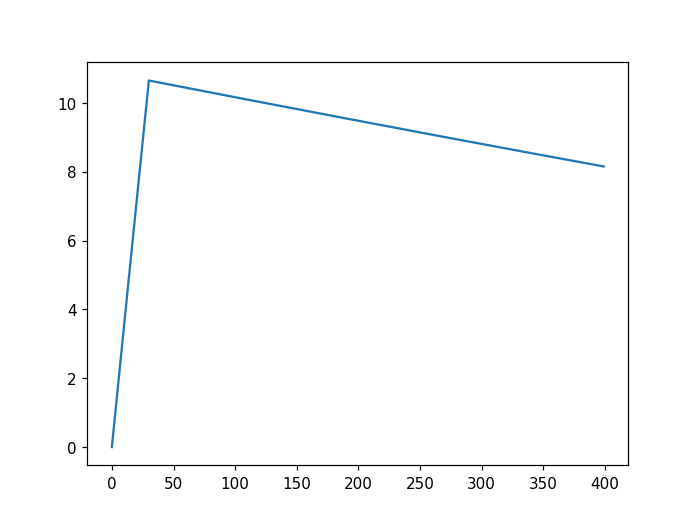

<IPython.core.display.Javascript object>


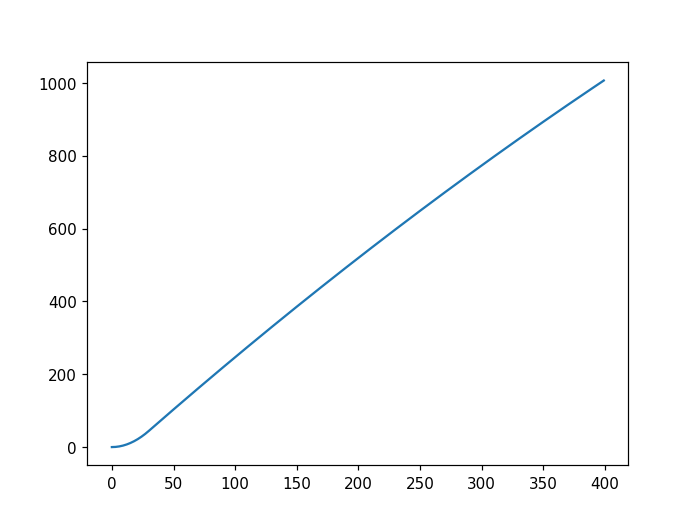

In [73]:
states_sim = simulator.data['_x']
plt.figure()
plt.plot(simulator.data['_time'],states_sim[:,1]*3.6)

plt.figure()
plt.plot(simulator.data['_time'],states_sim[:,0])